# 🚀 Spaceship Titanic

### ⚙️ Importing Libraries & Environment Setup

In [1501]:
import os
from typing import Any, Callable

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from colorama import Fore, Style
from numpy.typing import NDArray
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    explained_variance_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    root_mean_squared_error,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import LabelEncoder

In [1502]:
%matplotlib inline

pd.set_option("display.width", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

In [1503]:
should_save_submission = True

# Determine dataset directory based on environment
if os.path.exists("/kaggle/input/titanic"):
    dataset_path = "/kaggle/input/spaceship_titanic"  # Kaggle
    should_save_submission = True
elif os.path.exists("./dataset"):
    dataset_path = "./dataset"  # Local
else:
    raise FileNotFoundError("Dataset directory not found.")

## 🛠️ Utility Functions

In [1504]:
def evaluate_regression_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple regression model predictions on the given dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary where keys are
            model names and values are predicted target arrays corresponding to X.
        y (NDArray[np.float64]): True target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame with evaluation metrics (MAE, MSE, RMSE, R², EVS) for
            each model. Columns correspond to model names; rows correspond to metrics.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(), index=["MAE", "MSE", "RMSE", "R²", "EVS"]
    )

    for name, y_pred in predictions.items():
        metrics = {
            "MAE": mean_absolute_error(y, y_pred),
            "MSE": mean_squared_error(y, y_pred),
            "RMSE": root_mean_squared_error(y, y_pred),
            "R²": r2_score(y, y_pred),
            "EVS": explained_variance_score(y, y_pred),
        }

        evaluations.loc[:, name] = metrics

    return evaluations.astype(float)

In [1505]:
def evaluate_classification(
    y_pred: NDArray[np.float64], y_true: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        y_pred (NDArray[np.float64]): Predicted probabilities or binary outputs.
        y_true (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall, F1-score, and ROC AUC. Rows correspond to the metric names.
    """
    # If predictions are probabilities, binarize with threshold 0.5
    y_pred_bin = (y_pred > 0.5).astype(int)

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred_bin),
        "Precision": precision_score(y_true, y_pred_bin),
        "Recall": recall_score(y_true, y_pred_bin),
        "F1-score": f1_score(y_true, y_pred_bin),
        "ROC AUC": roc_auc_score(y_true, y_pred),
    }

    return pd.DataFrame.from_dict(metrics, orient="index", columns=["score"]).T

In [1506]:
def plot_confusion_matrix(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> None:
    """Display a confusion matrix using seaborn heatmap.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

In [1507]:
def plot_feature_importance(importance_df: pd.DataFrame) -> None:
    """Display feature importance barplot using seaborn.

    Args:
        importance_df (pd.DataFrame): DataFrame с двумя столбцами:
            'feature' — названия признаков,
            'importance' — значения важности.
    """
    importance_df = importance_df.sort_values(by="importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=importance_df,
        x="importance",
        y="feature",
        hue="feature",
        palette="viridis",
    )
    plt.title("Feature Importance (Gain)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

In [1508]:
class PandasProxy:
    """A proxy class that provides controlled access to a pandas DataFrame."""

    def __init__(
        self, get_df: Callable[[], pd.DataFrame], set_df: Callable[[pd.DataFrame], None]
    ) -> None:
        """Initialize the proxy with getter and setter functions.

        Args:
            get_df (Callable[[], pd.DataFrame]): Function to retrieve the DataFrame.
            set_df (Callable[[pd.DataFrame], None]): Function to set/update the
                DataFrame.
        """
        self._get_df = get_df
        self._set_df = set_df

    def __getitem__(self, key: Any) -> Any:
        """Retrieve an item from the proxied DataFrame."""
        return self._get_df()[key]

    def __setitem__(self, key: Any, value: Any) -> None:
        """Set a value in the proxied DataFrame and update it."""
        df = self._get_df()
        df[key] = value
        self._set_df(df)

    def __getattr__(self, name: str) -> Any:
        """Forward attribute access to the proxied DataFrame."""
        return getattr(self._get_df(), name)


class DatasetManager:
    """Manages training and testing datasets.

    This class maintains synchronization between the separate train/test DataFrames and
    their concatenated form. Updating the combined DataFrame automatically updates
    the individual train and test DataFrames.
    """

    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame) -> None:
        """Initialize DatasetManager with train and test DataFrames.

        Args:
            train_df (pd.DataFrame): Training data.
            test_df (pd.DataFrame): Testing data.
        """
        self._train_df = train_df.reset_index(drop=True)
        self._test_df = test_df.reset_index(drop=True)

        self._train_size = len(self._train_df)
        self._columns_to_drop_from_test = list(
            set(self._train_df.columns) - set(self._test_df.columns)
        )
        self._combined_df = pd.concat([self._train_df, self._test_df]).reset_index(
            drop=True
        )

        self._combined_df_proxy = PandasProxy(
            self._get_combined_df, self._set_combined_df
        )

        self._assign_names()

    def _assign_names(self) -> None:
        """Assign descriptive names to train, test, and combined DataFrames."""
        self._train_df.name = "Training Set"
        self._test_df.name = "Test Set"
        self._combined_df.name = "Combined Set"

    def _get_combined_df(self) -> pd.DataFrame:
        """Get the combined DataFrame of train and test datasets.

        Returns:
            pd.DataFrame: Concatenated DataFrame of train and test sets.
        """
        return self._combined_df

    def _set_combined_df(self, new_combined_df: pd.DataFrame) -> None:
        """Set the combined DataFrame and update the train and test DataFrames.

        Args:
            new_combined_df (pd.DataFrame): New combined DataFrame.
        """
        self._combined_df = new_combined_df
        self._train_df = self._combined_df.iloc[: self._train_size].reset_index(
            drop=True
        )
        self._test_df = (
            self._combined_df.iloc[self._train_size :]
            .drop(self._columns_to_drop_from_test, axis=1)
            .reset_index(drop=True)
        )
        self._assign_names()

    @property
    def combined_df(self) -> PandasProxy:
        """Get a proxy to the combined DataFrame of train and test datasets.

        Returns:
            PandasProxy: Proxy object allowing controlled access to the DataFrame.
        """
        return self._combined_df_proxy

    @combined_df.setter
    def combined_df(self, new_combined_df: pd.DataFrame) -> None:
        """Set the combined DataFrame and update the train and test DataFrames.

        Args:
            new_combined_df (pd.DataFrame): New combined DataFrame.
        """
        self._set_combined_df(new_combined_df)

    @property
    def train_df(self) -> pd.DataFrame:
        """Get the training DataFrame.

        Returns:
            pd.DataFrame: Training dataset.
        """
        return self._train_df

    @property
    def test_df(self) -> pd.DataFrame:
        """Get the testing DataFrame.

        Returns:
            pd.DataFrame: Testing dataset.
        """
        return self._test_df

    @property
    def train_test_dfs(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        """Get the separate train and test DataFrames.

        Returns:
            tuple[pd.DataFrame, pd.DataFrame]: Tuple containing (train_df, test_df).
        """
        return self._train_df, self._test_df

## 📥 Load and Inspect Dataset

In [1509]:
train_df = pd.read_csv(f"{dataset_path}/train.csv")
test_df = pd.read_csv(f"{dataset_path}/test.csv")
dm = DatasetManager(train_df, test_df)

In [1510]:
print(f"{Fore.MAGENTA}DataFrame Info:{Style.RESET_ALL}")
for df in dm.train_test_dfs:
    print(f"\n{Fore.CYAN}====== {df.name} ======{Style.RESET_ALL}")
    df.info()

DataFrame Info:

====== Training Set ======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB

====== Test Set ======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276


In [1511]:
print(f"{Fore.GREEN}DataFrame Description:{Style.RESET_ALL}")
for df in dm.train_test_dfs:
    print(f"\n{Fore.CYAN}====== {df.name} ======{Style.RESET_ALL}")
    print(df.describe(include="all"))

DataFrame Description:

====== Training Set ======
       PassengerId HomePlanet CryoSleep    Cabin  Destination          Age    VIP   RoomService  \
count         8693       8492      8476     8494         8511  8514.000000   8490   8512.000000   
unique        8693          3         2     6560            3          NaN      2           NaN   
top        0001_01      Earth     False  G/734/S  TRAPPIST-1e          NaN  False           NaN   
freq             1       4602      5439        8         5915          NaN   8291           NaN   
mean           NaN        NaN       NaN      NaN          NaN    28.827930    NaN    224.687617   
std            NaN        NaN       NaN      NaN          NaN    14.489021    NaN    666.717663   
min            NaN        NaN       NaN      NaN          NaN     0.000000    NaN      0.000000   
25%            NaN        NaN       NaN      NaN          NaN    19.000000    NaN      0.000000   
50%            NaN        NaN       NaN      NaN          

In [1512]:
print(f"{Fore.YELLOW}First Rows of DataFrame:{Style.RESET_ALL}")
for df in dm.train_test_dfs:
    print(f"\n{Fore.CYAN}====== {df.name} ======{Style.RESET_ALL}")
    print(df.head())

First Rows of DataFrame:

====== Training Set ======
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  FoodCourt  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False          0.0        0.0   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False        109.0        9.0   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True         43.0     3576.0   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False          0.0     1283.0   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False        303.0       70.0   

   ShoppingMall     Spa  VRDeck               Name  Transported  
0           0.0     0.0     0.0    Maham Ofracculy        False  
1          25.0   549.0    44.0       Juanna Vines         True  
2           0.0  6715.0    49.0      Altark Susent        False  
3         371.0  3329.0   193.0       Solam Susent        False  
4         151.0   565.0     2.0  Willy Santant

In [1513]:
print(f"{Fore.RED}Missing Values in Each Column:{Style.RESET_ALL}")
for df in dm.train_test_dfs:
    print(f"\n{Fore.CYAN}====== {df.name} ======{Style.RESET_ALL}")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({"Missing Count": missing, "Missing %": missing_percent})
    print(missing_df)

Missing Values in Each Column:

====== Training Set ======
              Missing Count  Missing %
PassengerId               0   0.000000
HomePlanet              201   2.312205
CryoSleep               217   2.496261
Cabin                   199   2.289198
Destination             182   2.093639
Age                     179   2.059128
VIP                     203   2.335212
RoomService             181   2.082135
FoodCourt               183   2.105142
ShoppingMall            208   2.392730
Spa                     183   2.105142
VRDeck                  188   2.162660
Name                    200   2.300702
Transported               0   0.000000

====== Test Set ======
              Missing Count  Missing %
PassengerId               0   0.000000
HomePlanet               87   2.034136
CryoSleep                93   2.174421
Cabin                   100   2.338087
Destination              92   2.151040
Age                      91   2.127660
VIP                      93   2.174421
RoomService         

## 🧹 Feature Engineering

#### 🆔 Group and Family Features

In [1514]:
dm.combined_df["GroupId"] = dm.combined_df["PassengerId"].str.split("_").str[0]

group_sizes = (
    dm.combined_df["PassengerId"]
    .str.split("_")
    .str[1]
    .astype(int)
    .groupby(dm.combined_df["GroupId"])
    .max()
)

dm.combined_df["GroupSize"] = dm.combined_df["GroupId"].map(group_sizes)

In [1515]:
dm.combined_df["Name_missing"] = dm.combined_df["Name"].isna().astype(int)
dm.combined_df["Name"] = dm.combined_df["Name"].fillna("Unknown")
dm.combined_df["Surname"] = dm.combined_df["Name"].str.split(" ").str[-1]
dm.combined_df["Surname"] = dm.combined_df["Surname"].fillna("Unknown")
dm.combined_df["WithFamily"] = (
    dm.combined_df["GroupId"]
    .map(dm.combined_df.groupby("GroupId")["Surname"].nunique() == 1)
    .astype(int)
)
dm.combined_df["IsAlone"] = (dm.combined_df["GroupSize"] == 1).astype(int)

#### 🛳️ Cabin Features

In [1516]:
cabin_data = dm.combined_df["Cabin"].apply(
    lambda s: s.split("/") if pd.notnull(s) and isinstance(s, str) else ["N", "N", "N"]
)

dm.combined_df["CabinDeck"] = cabin_data.apply(lambda s: s[0])
dm.combined_df["CabinNum"] = cabin_data.apply(lambda s: s[1])
dm.combined_df["CabinSide"] = cabin_data.apply(lambda s: s[2])
dm.combined_df["Cabin_missing"] = dm.combined_df["Cabin"].isna().astype(int)

#### ❄️ CryoSleep and Related Features

In [1517]:
dm.combined_df["CryoSleep"] = dm.combined_df["CryoSleep"].fillna(0).astype(int)
dm.combined_df.loc[
    dm.combined_df["CryoSleep"] == 1,
    ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
] = dm.combined_df.loc[
    dm.combined_df["CryoSleep"] == 1,
    ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
].fillna(
    0
)

#### 💸 Spending Features

In [1518]:
dm.combined_df["TotalSpend"] = dm.combined_df[
    ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
].sum(axis=1)
dm.combined_df["IsVipAndHighSpender"] = (
    dm.combined_df["VIP"]
    & (dm.combined_df["TotalSpend"] > dm.combined_df["TotalSpend"].median())
).astype(int)
dm.combined_df["GroupTotalSpend"] = dm.combined_df.groupby("GroupId")[
    "TotalSpend"
].transform("sum")

#### 🌍 HomePlanet и Destination

In [1519]:
dm.combined_df["HomePlanet_missing"] = dm.combined_df["HomePlanet"].isna().astype(int)
home_planet_mode = dm.combined_df["HomePlanet"].mode()[0]
dm.combined_df["HomePlanet"] = dm.combined_df.groupby("GroupId")[
    "HomePlanet"
].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else home_planet_mode)
)

dm.combined_df["Destination_missing"] = dm.combined_df["Destination"].isna().astype(int)
destination_mode = dm.combined_df["Destination"].mode()[0]
dm.combined_df["Destination"] = dm.combined_df.groupby("GroupId")[
    "Destination"
].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else destination_mode)
)

#### 🎂 Age and Missing Value Handling

In [1520]:
dm.combined_df["Age_missing"] = dm.combined_df["Age"].isna().astype(int)
dm.combined_df["Age"] = dm.combined_df["Age"].fillna(dm.combined_df["Age"].median())
dm.combined_df["Age"] = pd.qcut(dm.combined_df["Age"], 10)

dm.combined_df["RoomService_missing"] = dm.combined_df["RoomService"].isna().astype(int)
dm.combined_df["RoomService"] = dm.combined_df["RoomService"].fillna(
    dm.combined_df["RoomService"].median()
)

dm.combined_df["FoodCourt_missing"] = dm.combined_df["FoodCourt"].isna().astype(int)
dm.combined_df["FoodCourt"] = dm.combined_df["FoodCourt"].fillna(
    dm.combined_df["FoodCourt"].median()
)

dm.combined_df["ShoppingMall_missing"] = (
    dm.combined_df["ShoppingMall"].isna().astype(int)
)
dm.combined_df["ShoppingMall"] = dm.combined_df["ShoppingMall"].fillna(
    dm.combined_df["ShoppingMall"].median()
)

dm.combined_df["Spa_missing"] = dm.combined_df["Spa"].isna().astype(int)
dm.combined_df["Spa"] = dm.combined_df["Spa"].fillna(dm.combined_df["Spa"].median())

dm.combined_df["VRDeck_missing"] = dm.combined_df["VRDeck"].isna().astype(int)
dm.combined_df["VRDeck"] = dm.combined_df["VRDeck"].fillna(
    dm.combined_df["VRDeck"].median()
)

dm.combined_df["VIP_missing"] = dm.combined_df["VIP"].isna().astype(int)
dm.combined_df["VIP"] = (
    dm.combined_df["VIP"].fillna(dm.combined_df["VIP"].median()).astype(int)
)

#### 🔢 Label Encoding

In [1521]:
non_numeric_features = [
    "Transported",
    "HomePlanet",
    "Destination",
    "Age",
    "GroupId",
    "Surname",
    "CabinDeck",
    "CabinNum",
    "CabinSide",
]

le = LabelEncoder()

for feature in non_numeric_features:
    dm.combined_df[feature] = le.fit_transform(dm.combined_df[feature])

---

In [1522]:
dm.combined_df = dm.combined_df.drop(columns=["Name", "Cabin"])

In [1523]:
print(f"{Fore.RED}Missing Values in Each Column:{Style.RESET_ALL}")
for df in dm.train_test_dfs:
    print(f"\n{Fore.CYAN}====== {df.name} ======{Style.RESET_ALL}")
    print(df.isnull().sum())

Missing Values in Each Column:

====== Training Set ======
PassengerId             0
HomePlanet              0
CryoSleep               0
Destination             0
Age                     0
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Transported             0
GroupId                 0
GroupSize               0
Name_missing            0
Surname                 0
WithFamily              0
IsAlone                 0
CabinDeck               0
CabinNum                0
CabinSide               0
Cabin_missing           0
TotalSpend              0
IsVipAndHighSpender     0
GroupTotalSpend         0
HomePlanet_missing      0
Destination_missing     0
Age_missing             0
RoomService_missing     0
FoodCourt_missing       0
ShoppingMall_missing    0
Spa_missing             0
VRDeck_missing          0
VIP_missing             0
dtype: int64

====== Test Set ======
PassengerId         

## 📊 Exploratory Data Visualizations

#### 💀 General Survival Analysis

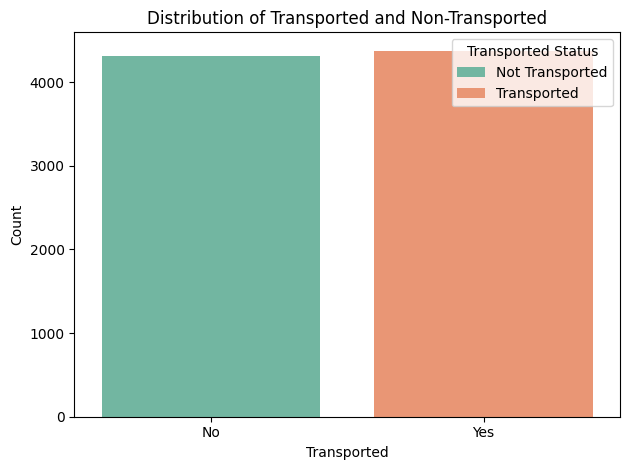

In [1524]:
sns.countplot(x="Transported", data=dm.train_df, hue="Transported", palette="Set2")
plt.title("Distribution of Transported and Non-Transported")
plt.xlabel("Transported")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["No", "Yes"])
plt.legend(title="Transported Status", labels=["Not Transported", "Transported"])
plt.tight_layout()
plt.show()

#### 🔗 Feature Correlation Matrix

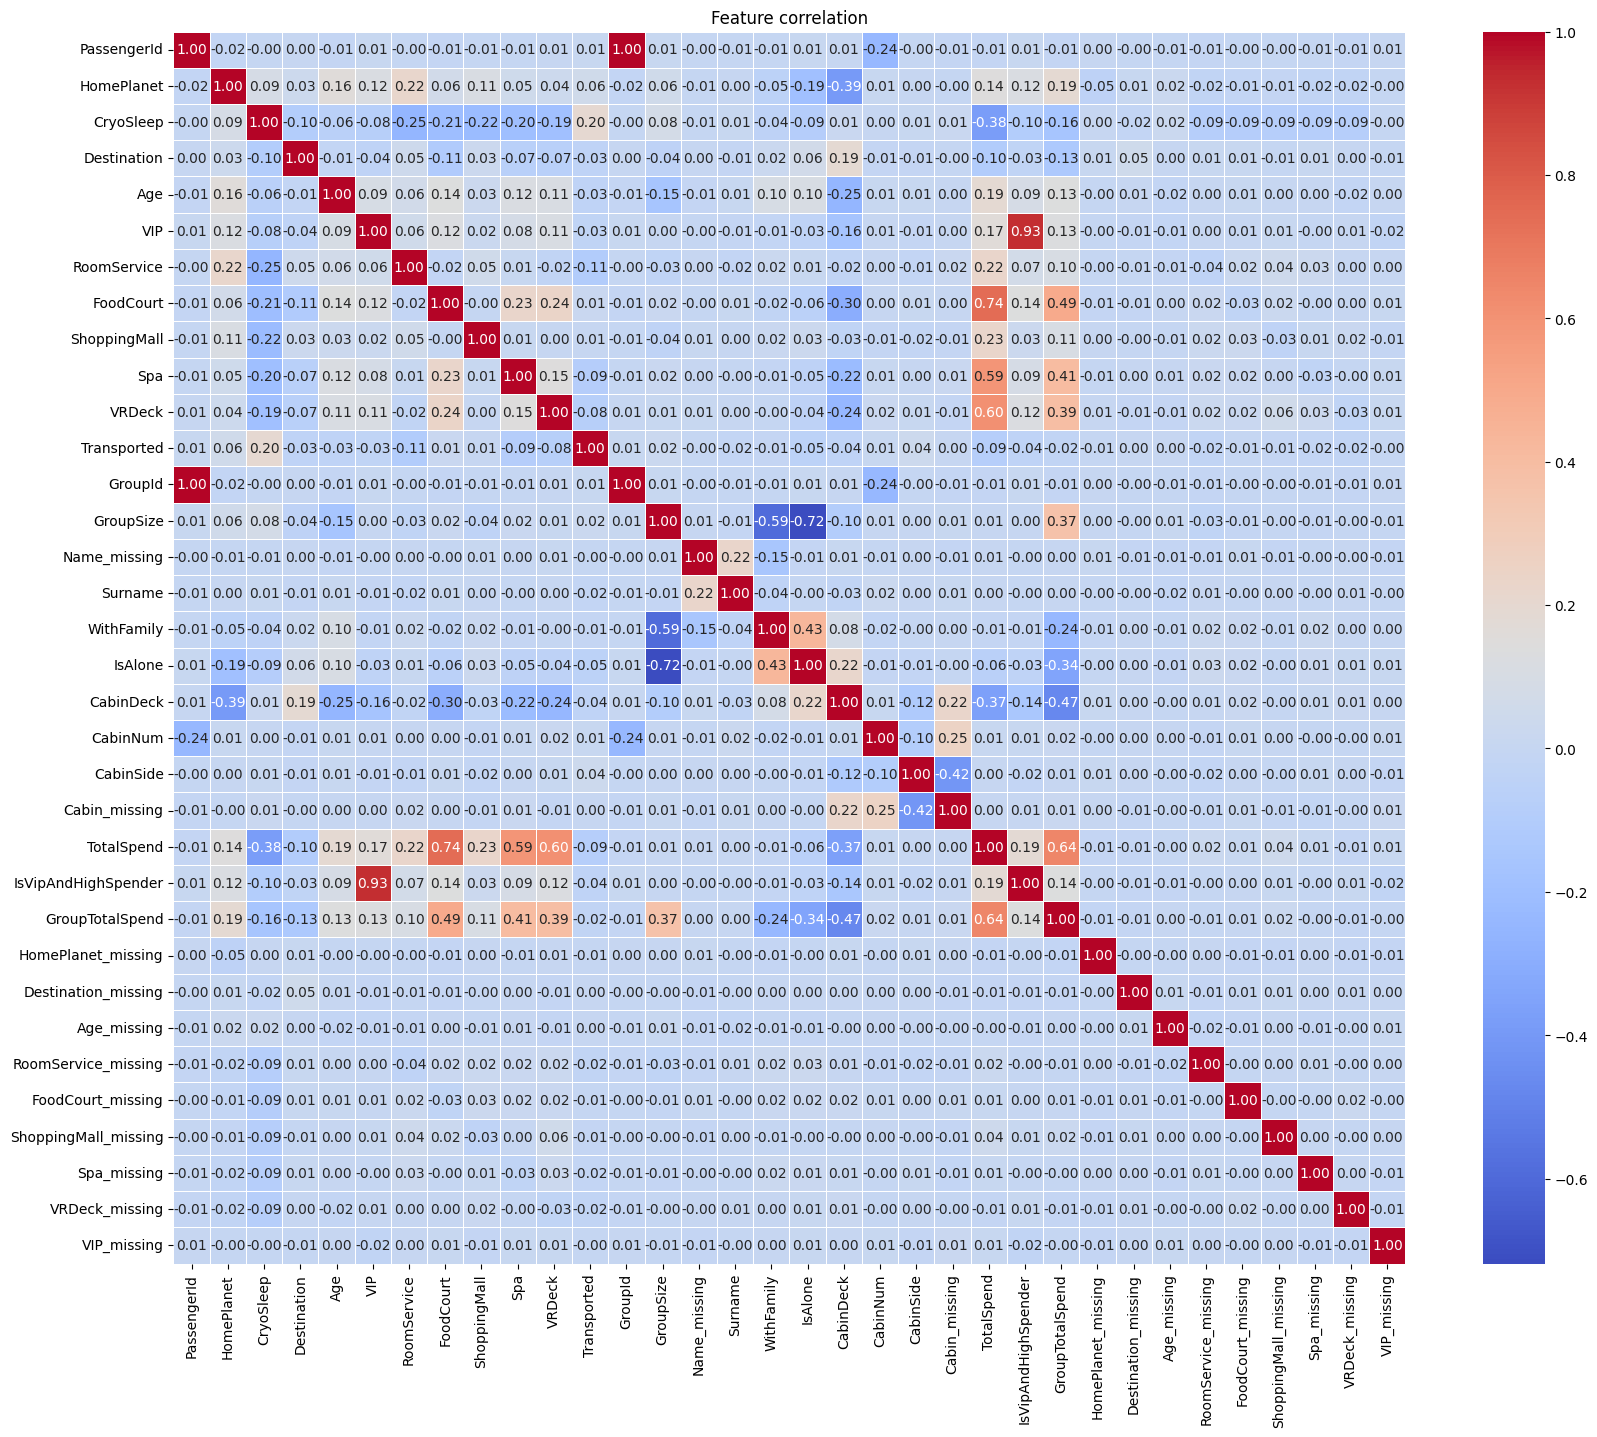

In [1525]:
corr = dm.combined_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Feature correlation")
plt.show()

#### 💰 Passenger Wealth vs Transport Status

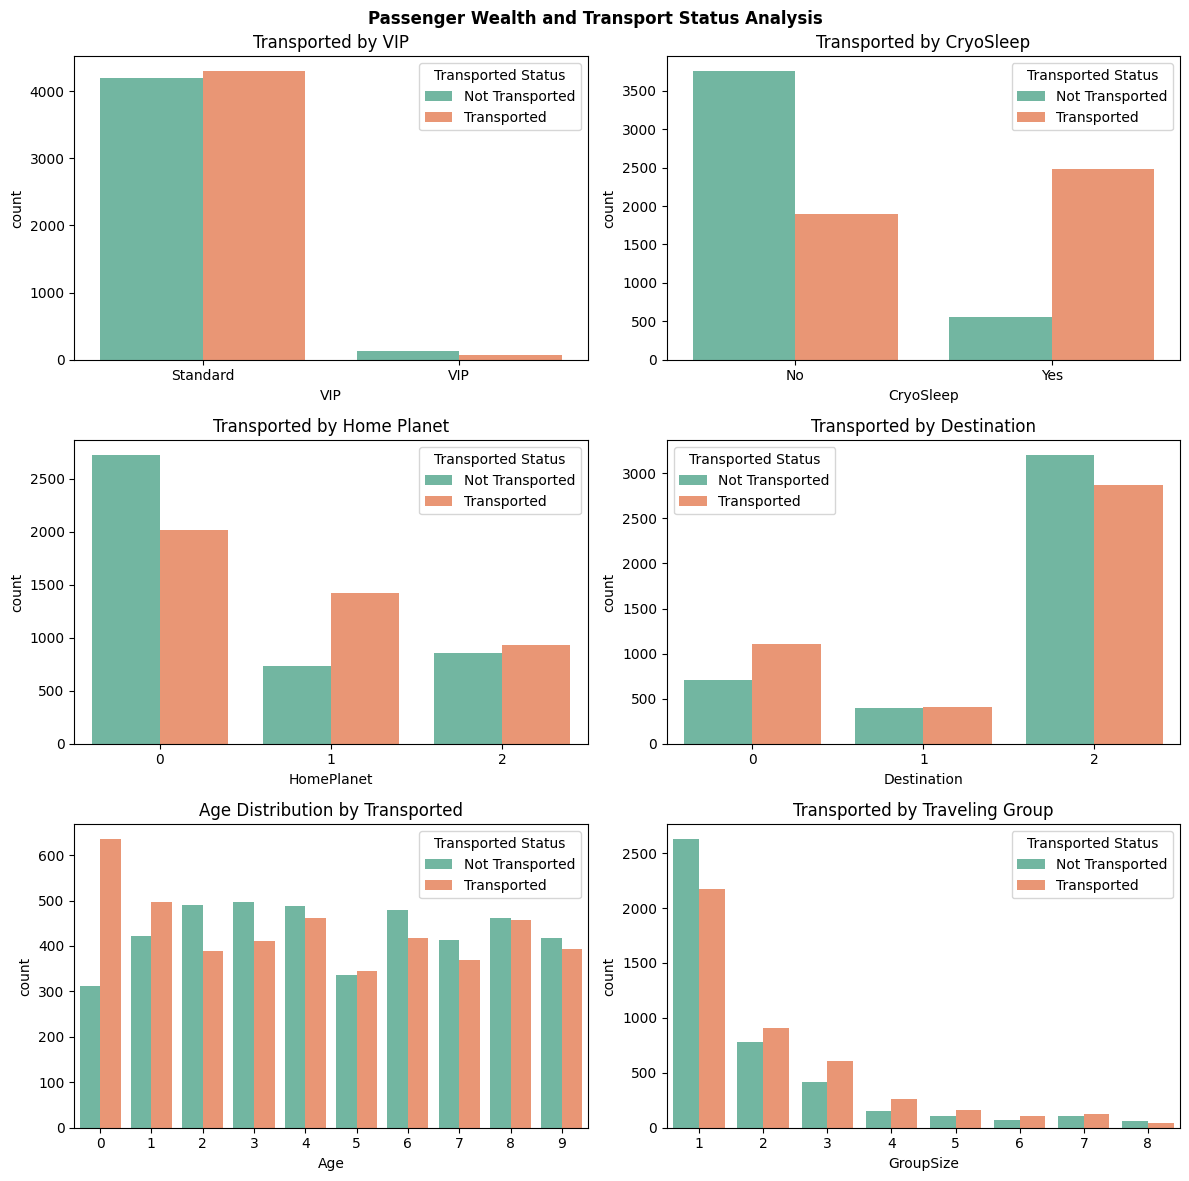

In [1526]:
palette = "Set2"

fig = plt.figure(figsize=(12, 12))
fig.suptitle("Passenger Wealth and Transport Status Analysis", fontweight="bold")

ax1 = plt.subplot2grid((3, 2), (0, 0))
sns.countplot(x="VIP", hue="Transported", data=dm.train_df, ax=ax1, palette=palette)
ax1.set_title("Transported by VIP")
ax1.set_xticks(ticks=[0, 1], labels=["Standard", "VIP"])
ax1.legend(title="Transported Status", labels=["Not Transported", "Transported"])

ax2 = plt.subplot2grid((3, 2), (0, 1))
sns.countplot(x="CryoSleep", hue="Transported", data=dm.train_df, ax=ax2, palette=palette)
ax2.set_title("Transported by CryoSleep")
ax2.set_xticks(ticks=[0, 1], labels=["No", "Yes"])
ax2.legend(title="Transported Status", labels=["Not Transported", "Transported"])

ax3 = plt.subplot2grid((3, 2), (1, 0))
sns.countplot(x="HomePlanet", hue="Transported", data=dm.train_df, ax=ax3, palette=palette)
ax3.set_title("Transported by Home Planet")
ax3.legend(title="Transported Status", labels=["Not Transported", "Transported"])

ax4 = plt.subplot2grid((3, 2), (1, 1))
sns.countplot(x="Destination", hue="Transported", data=dm.train_df, ax=ax4, palette=palette)
ax4.set_title("Transported by Destination")
ax4.legend(title="Transported Status", labels=["Not Transported", "Transported"])

ax3 = plt.subplot2grid((3, 2), (2, 0))
sns.countplot(x="Age", hue="Transported", data=dm.train_df, ax=ax3, palette=palette)
ax3.set_title("Age Distribution by Transported")
ax3.legend(title="Transported Status", labels=["Not Transported", "Transported"])

ax4 = plt.subplot2grid((3, 2), (2, 1))
sns.countplot(x="GroupSize", hue="Transported", data=dm.train_df, ax=ax4, palette=palette)
ax4.set_title("Transported by Traveling Group")
ax4.legend(title="Transported Status", labels=["Not Transported", "Transported"])

plt.tight_layout()
plt.show()

## 🧪 Model Training

In [1527]:
features = [
    "HomePlanet",
    "CryoSleep",
    "Destination",
    "Age",
    "VIP",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "GroupId",
    "GroupSize",
    "Name_missing",
    "Surname",
    "WithFamily",
    "IsAlone",
    "CabinDeck",
    "CabinNum",
    "CabinSide",
    "Cabin_missing",
    "TotalSpend",
    "IsVipAndHighSpender",
    "GroupTotalSpend",
    "HomePlanet_missing",
    "Destination_missing",
    "Age_missing",
    "RoomService_missing",
    "FoodCourt_missing",
    "ShoppingMall_missing",
    "Spa_missing",
    "VRDeck_missing",
    "VIP_missing",
]

X, y = dm.train_df[features], dm.train_df["Transported"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [1528]:
class Objective:
    """Objective function class for Optuna hyperparameter optimization.

    This class wraps training and evaluation logic to be used in Optuna's optimization
    loop. It supports randomized cross-validation and logs the cross-validated accuracy
    for each trial.
    """

    def __init__(
        self,
        X: NDArray[np.float64],
        y: NDArray[np.float64],
        random_state: int | None = None,
    ) -> None:
        """Initializes the Objective class.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Target vector.
            random_state (int | None): Random seed for reproducibility. Default is None.
        """
        self.X = X
        self.y = y
        self.random_state = random_state

    def __call__(self, trial: optuna.trial.Trial) -> float:
        """Objective function for Optuna study to optimize hyperparameters.

        Parameters:
            trial (Trial): A single trial object that suggests hyperparameter values.

        Returns:
            float: Cross-validated accuracy score (mean of folds).
        """
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 10, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "eval_metric": "logloss",
            "random_state": self.random_state,
        }

        model = xgb.XGBClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        scores = cross_val_score(model, self.X, self.y, cv=cv, scoring="roc_auc")

        score = np.median(scores)
        trial.set_user_attr("cv_accuracy", score)
        return score


study = optuna.create_study(
    direction="maximize",
    study_name="xgb",
    sampler=optuna.samplers.TPESampler(seed=42),
)

objective = Objective(X_train, y_train, random_state=42)
study.optimize(objective, n_trials=100)

[I 2025-08-02 13:52:21,805] A new study created in memory with name: xgb
[I 2025-08-02 13:52:24,106] Trial 0 finished with value: 0.8911946169772257 and parameters: {'n_estimators': 118, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 0.8911946169772257.
[I 2025-08-02 13:52:24,409] Trial 1 finished with value: 0.8961908207566675 and parameters: {'n_estimators': 55, 'max_depth': 3, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 0.8961908207566675.
[I 2025-08-02 13:52:24,947] Trial 2 finished with value: 0.8795217391304347 and parameters: {'n_estimators': 15, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 0.8961908207566675.
[I 2025-08-02 13:52:25,498] Trial 3 finished with value: 0

### 📊 Model Evaluation

In [1529]:
model = xgb.XGBClassifier(**study.best_params, eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

y_proba = model.predict_proba(X_valid)[:, 1]
y_pred = y_proba > 0.5

In [1530]:
print(f"{Fore.GREEN}Best hyperparameters found:{Style.RESET_ALL}", study.best_params)
print(f"{Fore.YELLOW}Best CV score:{Style.RESET_ALL}", study.best_value)

Best hyperparameters found: {'n_estimators': 254, 'max_depth': 5, 'learning_rate': 0.021943807363629726, 'subsample': 0.9845124317828715, 'colsample_bytree': 0.8473402680590081}
Best CV score: 0.9022701863354037


In [1531]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()

In [1532]:
evaluate_classification(y_proba, y_valid)

,Accuracy,Precision,Recall,F1-score,ROC AUC
score,0.79931,0.782888,0.833713,0.807501,0.892602


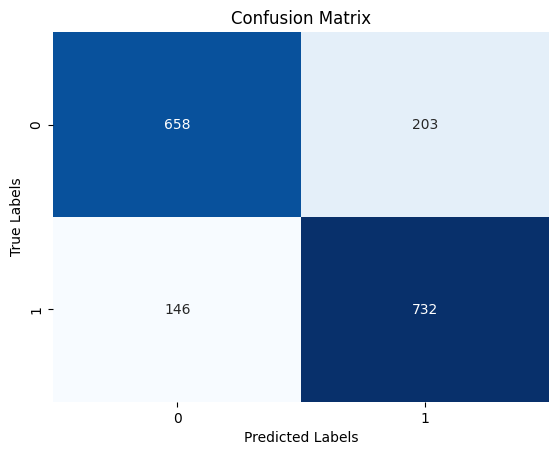

In [1533]:
plot_confusion_matrix(y_valid, y_pred)

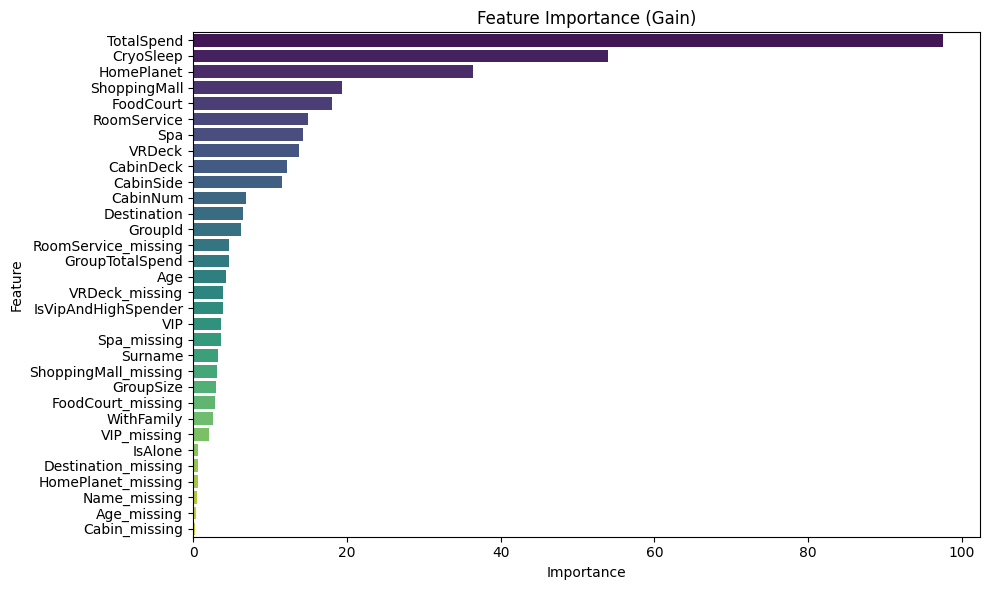

In [1534]:
importance_dict = model.get_booster().get_score(importance_type="gain")

importance_df = pd.DataFrame(
    {
        "feature": list(importance_dict.keys()),
        "importance": list(importance_dict.values()),
    }
)

plot_feature_importance(importance_df)

### 🧠 Final Model Training

In [1535]:
final_model = xgb.XGBClassifier(
    **study.best_params, eval_metric="logloss", random_state=42
)
final_model.fit(X, y)

submission_predictions = final_model.predict(dm.test_df[features])

if should_save_submission:
    submission_df = pd.DataFrame(
        {
            "PassengerId": dm.test_df["PassengerId"],
            "Transported": submission_predictions.astype(bool),
        }
    )
    submission_df.to_csv("submission.csv", index=False)
    print(f"{Fore.GREEN}Submission was successfully saved!{Style.RESET_ALL}")
else:
    print(f"{Fore.YELLOW}Submission not saved.{Style.RESET_ALL}")

Submission was successfully saved!
